In [1]:
%matplotlib inline

# Alle Pakete importieren

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
from ipywidgets import interact
from lmfit.models import ConstantModel, GaussianModel

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams.update({"font.size": 22})

# Überblick der vorhandenen Dateien

In [3]:
for file in (Path(".") / "ARM1_Neu").glob("*.txt"):
    print(file)

ARM1_Neu\932.85.txt
ARM1_Neu\932.86.txt
ARM1_Neu\932.87.txt
ARM1_Neu\932.88.txt
ARM1_Neu\932.89.txt
ARM1_Neu\932.9.txt
ARM1_Neu\932.91.txt
ARM1_Neu\932.92.txt
ARM1_Neu\932.93.txt
ARM1_Neu\932.94.txt
ARM1_Neu\932.95.txt
ARM1_Neu\932.96.txt
ARM1_Neu\932.97.txt
ARM1_Neu\932.98.txt
ARM1_Neu\932.99.txt
ARM1_Neu\932.992.txt
ARM1_Neu\932.994.txt
ARM1_Neu\932.996.txt
ARM1_Neu\932.998.txt
ARM1_Neu\933,0.txt
ARM1_Neu\933,002.txt
ARM1_Neu\933,004.txt
ARM1_Neu\933,006.txt
ARM1_Neu\933,008.txt
ARM1_Neu\933,01.txt
ARM1_Neu\933,012.txt
ARM1_Neu\933,014.txt
ARM1_Neu\933,016.txt
ARM1_Neu\933,018.txt
ARM1_Neu\933,02.txt
ARM1_Neu\933,022.txt
ARM1_Neu\933,024.txt
ARM1_Neu\933,026.txt
ARM1_Neu\933,028.txt
ARM1_Neu\933,03.txt
ARM1_Neu\933,032.txt
ARM1_Neu\933,034.txt
ARM1_Neu\933,036.txt
ARM1_Neu\933,038.txt
ARM1_Neu\933,04.txt
ARM1_Neu\933,042.txt
ARM1_Neu\933,044.txt
ARM1_Neu\933,046.txt
ARM1_Neu\933,048.txt
ARM1_Neu\933,05.txt
ARM1_Neu\933,052.txt
ARM1_Neu\933,054.txt
ARM1_Neu\933,056.txt
ARM1_Neu\933,05

# Einlesen der Dateien

In [4]:
Messungen = []
for Messung in (Path(".") / "ARM1_Neu").glob("*.txt"):
    full_data = pd.read_csv(Messung, sep=r"\s+", skiprows=1, names=["AA", "Wellenlänge", "Counts"])
    Messungen.append(full_data)

# Interaktiver Plot, durchscrollen der vorhanden Dateien

interactive(children=(IntSlider(value=41, description='index', max=82), Output()), _dom_classes=('widget-inter…

<function __main__.plotMessungen(index)>

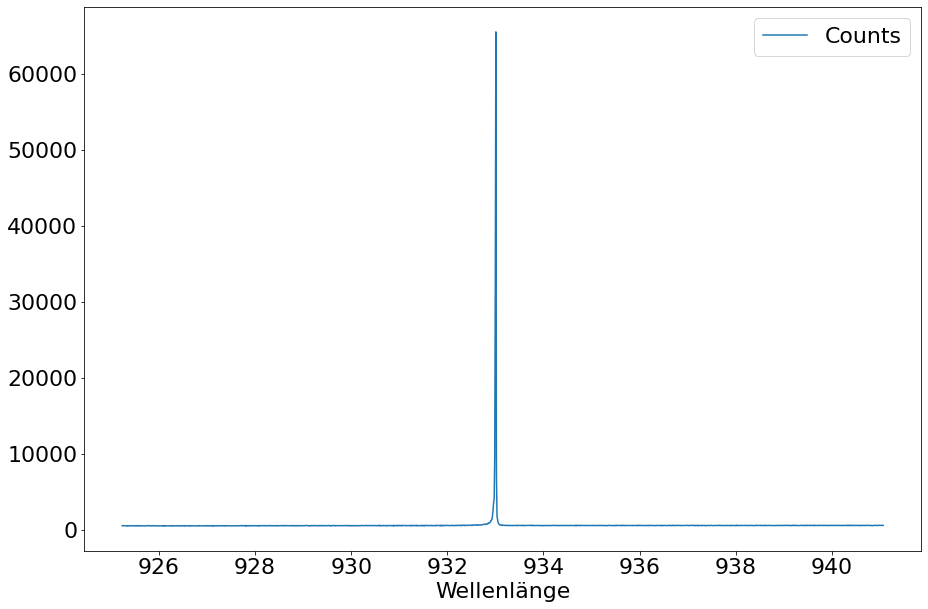

In [5]:
def plotMessungen(index):
    return Messungen[index].plot(x="Wellenlänge", y="Counts")


interact(plotMessungen, index=(0, len(Messungen) - 1))

In [6]:
full_data.describe()

,AA,Wellenlänge,Counts
count,1339.000000,1339.000000,1339.000000
mean,1.328692,933.152388,597.774459
std,0.006515,4.575588,23.172098
min,1.317483,925.236100,525.000000
25%,1.323047,929.194250,583.000000
50%,1.328660,933.152400,600.000000
75%,1.334319,937.110500,614.000000
max,1.340028,941.068700,656.000000


# Widget Interactive installieren
!pip install jupyterlab_widgets

# Fit one Peak definition

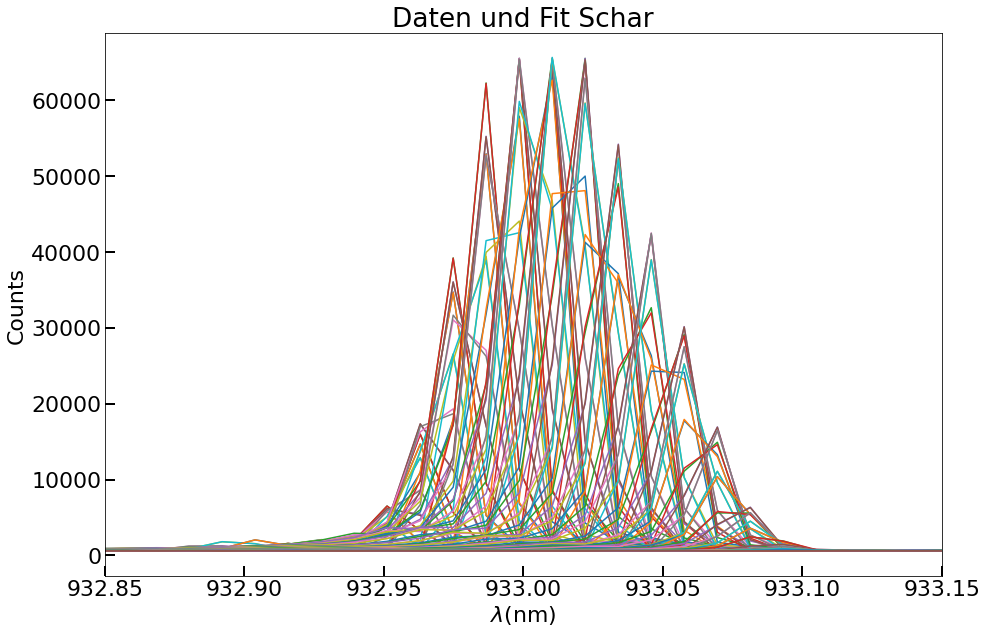

In [7]:
def fit_1_peak(data_series, center=933.0, FWHM=0.1, vary_offset=True):
    """Fit data with 1 gaussian peak and a constant offset."""
    gauss_FWHM_correction = 2.3548200
    sigma = FWHM / gauss_FWHM_correction

    amplitude_correction = sigma * np.sqrt(2 * np.pi)

    amplitude = (data_series.max() - 1) * amplitude_correction

    model_1_gauss = GaussianModel()
    params = model_1_gauss.make_params(
        amplitude=amplitude,
        center=center,
        sigma=sigma,
    )
    if vary_offset:
        model_1_gauss += ConstantModel()
        params.add("c", value=1, min=0)
    y = data_series.dropna().values
    x = data_series.dropna().index.values
    fit = model_1_gauss.fit(y, params=params, x=x)
    return fit


ax = plt.subplot()
Amplituden = []
Center = []
for Messung in Messungen:
    data_series = Messung.set_index("Wellenlänge")["Counts"]
    fit = fit_1_peak(data_series)
    Amplituden.append(fit.params["height"].value)
    Center.append(fit.params["center"].value)
    FittedData = pd.Series(fit.best_fit, index=data_series.index)
    data_series.plot(title="Daten und Fit Schar", ax=ax)
    FittedData.plot(ax=ax)
    ax.tick_params(direction="in", length=10, width=2)
    ax.set_xlim([932.85, 933.15])
    ax.set_xlabel("$\\lambda$(nm)")
    ax.set_ylabel("Counts")
    plt.savefig("Schar_Arm1.png")

# Fit der Amplituden

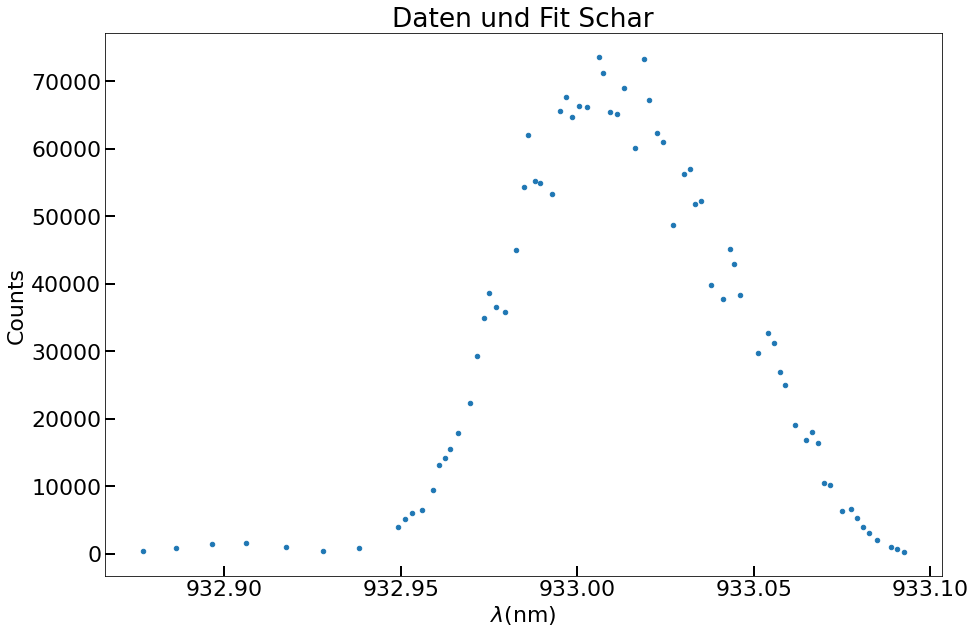

In [8]:
Amplitudes = pd.DataFrame({"Amplituden": Amplituden, "Center": Center}).sort_values(by="Center")
Amplitudes.set_index("Center", inplace=True, drop=False)
# Fits von verrauschten, unnützen Bullshit entfernen
Amplitudes = Amplitudes[Amplitudes.index < 935]
ax = Amplitudes.plot(x="Center", y="Amplituden", title="Daten und Fit Schar", kind="scatter")
ax.set_xlabel("$\\lambda$(nm)")
ax.set_ylabel("Counts")
ax.tick_params(direction="in", length=10, width=2)

# bereinigte Daten und Fit aller Peak-Amplituden

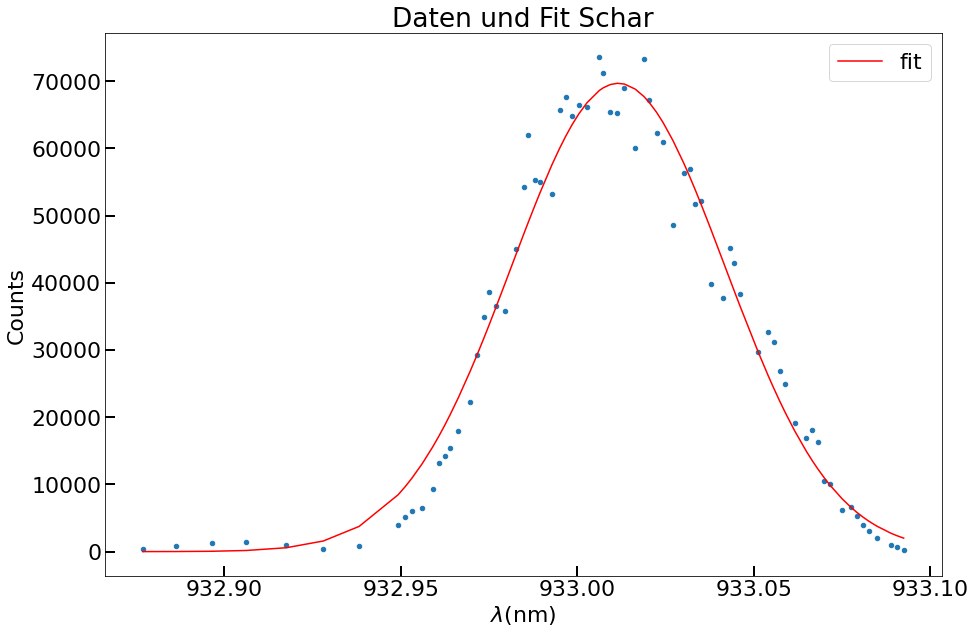

In [9]:
Amplitudes = pd.DataFrame({"Amplituden": Amplituden, "Center": Center}).sort_values(by="Center")
Amplitudes.set_index("Center", inplace=True, drop=False)
# Fits von verrauschten, unnützen Bullshit entfernen
Amplitudes = Amplitudes[Amplitudes.index < 935]
ax = Amplitudes.plot(x="Center", y="Amplituden", title="Daten und Fit Schar", kind="scatter")
fit = fit_1_peak(Amplitudes["Amplituden"], center=933, FWHM=0.1, vary_offset=False)
Amplitudes["fit"] = fit.best_fit
Amplitudes.plot(y="fit", ax=ax, color="red")
ax.set_xlabel("$\\lambda$(nm)")
ax.set_ylabel("Counts")
ax.tick_params(direction="in", length=10, width=2)

# Bestimmung der Auflösung

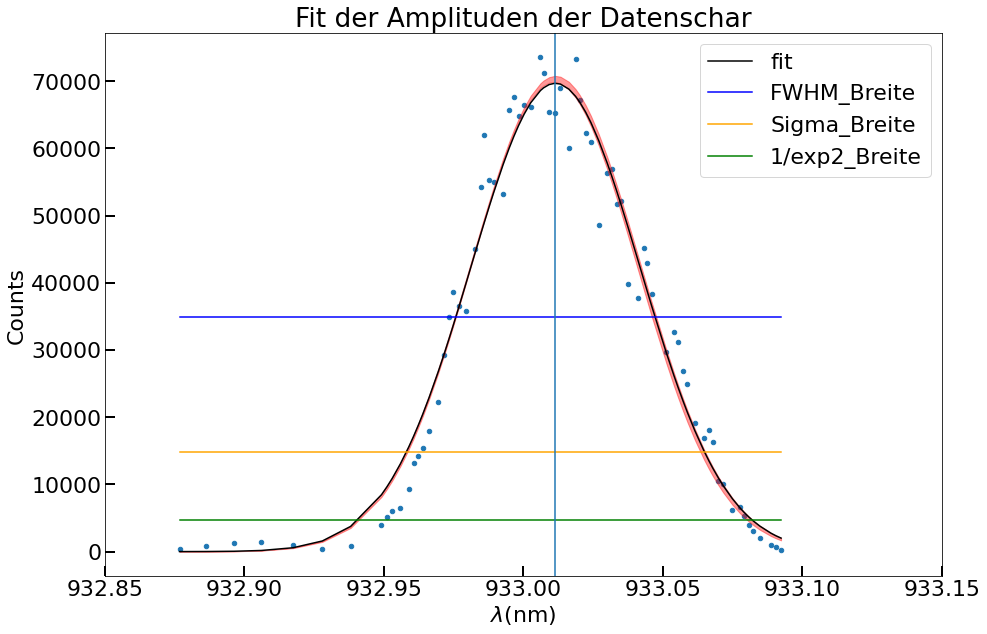

In [10]:
Full_Height = fit.params["height"].value
FWHM_Höhe = Full_Height / 2
Sigma_Höhe = FWHM_Höhe / 2.3548200
exp2_Höhe = FWHM_Höhe / np.exp(2)

Amplitudes["FWHM_Breite"] = FWHM_Höhe
Amplitudes["Sigma_Breite"] = Sigma_Höhe
Amplitudes["1/exp2_Breite"] = exp2_Höhe
ax = Amplitudes.plot(
    x="Center", y="Amplituden", title="Fit der Amplituden der Datenschar", kind="scatter"
)
Amplitudes.plot(
    y=["fit", "FWHM_Breite", "Sigma_Breite", "1/exp2_Breite"],
    ax=ax,
    color=["black", "blue", "orange", "green"],
)

x = Amplitudes["Center"]

upA = fit.params["amplitude"].value + 1 * fit.params["amplitude"].stderr
upC = fit.params["center"].value + 0 * fit.params["center"].stderr
upS = fit.params["sigma"].value + 0 * fit.params["sigma"].stderr
downA = fit.params["amplitude"].value - 1 * fit.params["amplitude"].stderr
downC = fit.params["center"].value - 1 * fit.params["center"].stderr
downS = fit.params["sigma"].value - 1 * fit.params["sigma"].stderr

# für R-square Wert
A = fit.params["amplitude"].value
C = fit.params["center"].value
S = fit.params["sigma"].value
Model = A / np.sqrt(S ** 2 * 2 * np.pi) * np.exp(-((x - C) ** 2) / (2 * S ** 2))

Schlauch_up = upA / np.sqrt(upS ** 2 * 2 * np.pi) * np.exp(-((x - upC) ** 2) / (2 * upS ** 2))
Schlauch_down = (
    downA / np.sqrt(downS ** 2 * 2 * np.pi) * np.exp(-((x - downC) ** 2) / (2 * downS ** 2))
)

ax.fill_between(x, Schlauch_up, Schlauch_down, alpha=0.4, color="red")
ax.set_xlim([932.85, 933.15])
ax.set_xlabel("$\\lambda$(nm)")
ax.set_ylabel("Counts")
ax.tick_params(direction="in", length=10, width=2)
ax.axvline(x=fit.params["center"].value, ymin=0, ymax=fit.params["amplitude"].value)


plt.savefig("Auflösung_Arm1_Sigma.png")

# Fit Report

In [11]:
print(fit.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 73
    # variables        = 3
    chi-square         = 1.3356e+09
    reduced chi-square = 19080537.2
    Akaike info crit   = 1226.72171
    Bayesian info crit = 1233.59309
[[Variables]]
    amplitude:  5304.18969 +/- 84.1980670 (1.59%) (init = 7827.391)
    center:     933.011555 +/- 5.5107e-04 (0.00%) (init = 933)
    sigma:      0.03036532 +/- 5.6668e-04 (1.87%) (init = 0.04246609)
    fwhm:       0.07150486 +/- 0.00133442 (1.87%) == '2.3548200*sigma'
    height:     69686.9223 +/- 1084.51027 (1.56%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.604
